In [1]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import pandas as pd
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

from __future__ import print_function
import numpy as np
np.random.seed(1)
import sys
import sklearn
import sklearn.ensemble
#%load_ext autoreload
#%autoreload 2
import anchor
from anchor import utils
from anchor import anchor_tabular


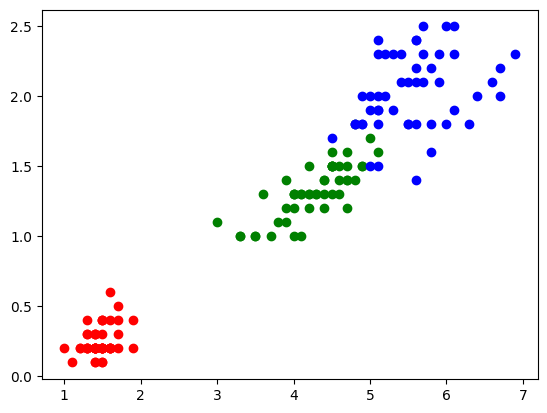

In [2]:
iris = sklearn.datasets.load_iris()
features = iris.data
labels = iris.target

plt.figure()
plt.scatter(features[labels == 0,2], features[labels == 0, 3], c = 'r', label = 'Setosa')
plt.scatter(features[labels == 1,2], features[labels == 1, 3], c = 'g', label = 'Versicolor')
plt.scatter(features[labels == 2,2], features[labels == 2, 3], c = 'b', label = 'Virginica')
plt.show()

features = iris.data
labels = iris.target

features = features[labels != 0] # Drop class 0
features = features[:,2:] # Drop features 0 and 1

labels = labels[labels != 0] # Drop class 0

In [4]:
labels



#replace labels==2 with 0
labels[labels == 2] = 0
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(features, labels, train_size=0.80)


In [68]:
c=sklearn.linear_model.LogisticRegression()
c.fit(train, labels_train)
predict=c.predict(test)
predict


array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [69]:
feature_names = iris.feature_names[2:]
feature_names
target_names = iris.target_names[1:][::-1]
target_names

array(['virginica', 'versicolor'], dtype='<U10')

In [70]:
explainer = anchor_tabular.AnchorTabularExplainer(
    target_names,
    feature_names,
    train)



In [71]:
idx=0
print('Prediction: ', explainer.class_names[c.predict(test[idx].reshape(1, -1))[0]])
exp = explainer.explain_instance(test[idx], c.predict, threshold=0.95)

Prediction:  virginica


In [72]:

print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: petal length (cm) > 5.50
Precision: 1.00
Coverage: 0.22


In [73]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(features, labels, train_size=0.80)
train_np=train
test_np=test

train = torch.from_numpy(train)
test = torch.from_numpy(test)

labels_train = torch.from_numpy(labels_train).reshape(-1,1)
labels_test = torch.from_numpy(labels_test).reshape(-1,1)


labels_train

tensor([[0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],

## 2


In [50]:
class LogisticRegressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
    def class_probabilities(self, x):
        with torch.no_grad():
            x = self.forward(x)
            class_probs = torch.cat((1-x, x), dim = 1)
        return class_probs.reshape(-1,2)
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            predicted_class = x.detach().round()
        return predicted_class.reshape(-1,1)

model = LogisticRegressor(2,1)

In [51]:

# Hyperparameters
lr = 0.05
num_epochs = 500

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

train = train.float()
test = test.float()
labels_train = labels_train.float()
labels_test = labels_test.float()

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    optimizer.zero_grad()
    outputs = model.forward(train)
    loss = loss_fn(outputs, labels_train)
    loss.backward()
    optimizer.step()
    
    # Calculate training and validation accuracy every epoch
    training_accuracy = 0
    test_accuracy = 0
     
    model.eval()
    outputs = model.predict(train)
    training_accuracy = (outputs == labels_train).float().mean()
    outputs = model.predict(test)
    test_accuracy = (outputs == labels_test).float().mean()
    #print('Training accuracy = {} | Test accuracy = {}'.format(training_accuracy, test_accuracy))
    
    # Print the loss every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}' + ' Training accuracy = {} | Test accuracy = {}'.format(training_accuracy, test_accuracy))
        
print('Done!')



Epoch [1/500], Loss: 1.1693434715270996 Training accuracy = 0.550000011920929 | Test accuracy = 0.30000001192092896
Epoch [2/500], Loss: 1.0432627201080322 Training accuracy = 0.550000011920929 | Test accuracy = 0.30000001192092896
Epoch [3/500], Loss: 0.9258748888969421 Training accuracy = 0.550000011920929 | Test accuracy = 0.30000001192092896
Epoch [4/500], Loss: 0.8204602003097534 Training accuracy = 0.550000011920929 | Test accuracy = 0.30000001192092896
Epoch [5/500], Loss: 0.7310886979103088 Training accuracy = 0.550000011920929 | Test accuracy = 0.30000001192092896
Epoch [6/500], Loss: 0.662301242351532 Training accuracy = 0.550000011920929 | Test accuracy = 0.30000001192092896
Epoch [7/500], Loss: 0.6181621551513672 Training accuracy = 0.5874999761581421 | Test accuracy = 0.30000001192092896
Epoch [8/500], Loss: 0.6004412770271301 Training accuracy = 0.75 | Test accuracy = 0.6000000238418579
Epoch [9/500], Loss: 0.6063541769981384 Training accuracy = 0.8500000238418579 | Test 

In [63]:

explainer = anchor_tabular.AnchorTabularExplainer(
    target_names,
    feature_names,
    train.numpy()) 

def predict_fn(x):
    return model.predict(torch.tensor(x).float()).numpy().astype(int)
    


idx = 0
with torch.no_grad():
    test_input = torch.tensor(test[idx], dtype=torch.float32).reshape(1, -1)
    predicted_class = model.predict(test_input)
    print('Prediction: ', explainer.class_names[int(predicted_class[0].item())])  # Access item directly and cast to int
    
    # Convert test_input to a NumPy array before passing it to explain_instance
    test_input_np = test_input.numpy()[0]
    
    # Define a function to predict using the model and return NumPy array
    def predict_fn(x):
        return model.predict(torch.tensor(x).float()).numpy().astype(int).reshape(-1)
    
    # Pass the predict function to explain_instance
    exp = explainer.explain_instance(test_input_np, predict_fn, threshold=0.95)

Prediction:  versicolor


/tmp/ipykernel_239047/3509775709.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input = torch.tensor(test[idx], dtype=torch.float32).reshape(1, -1)


In [74]:

print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: petal length (cm) > 5.50
Precision: 1.00
Coverage: 0.22
